# Comparing Base vs. Fine-Tuned GPT-OSS 20B: Jordan Peterson Analysis

## Overview

This notebook provides a quantitative comparison between:
- **Base model**: `unsloth/gpt-oss-20b-unsloth-bnb-4bit` — the original GPT-OSS 20B model with no domain specialization
- **Fine-tuned model**: The same base model with LoRA adapters trained on ~768,000 words from four Jordan Peterson books

### What We're Measuring

The core question is: *how much more "Jordan Peterson-like" is the fine-tuned model compared to the base model?*

We measure this along six independent axes:

| Metric | What It Measures | Expected Result |
|--------|-----------------|----------------|
| **Perplexity** | How "surprised" the model is by Peterson's actual writing | Fine-tuned = lower (more familiar with his style) |
| **Semantic Similarity** | Cosine distance between model outputs and real Peterson passages | Fine-tuned = higher similarity |
| **Keyword Density** | Frequency of Peterson's characteristic vocabulary in responses | Fine-tuned = higher |
| **Vocabulary Richness** | Type-Token Ratio — diversity of unique words used | Fine-tuned ≈ higher (richer vocabulary) |
| **Response Length** | Average words per response | Fine-tuned = longer (Peterson is verbose) |
| **Word Distribution** | Which words dominate responses (visualized as word clouds) | Fine-tuned = Peterson-specific terms |

### Memory Management Strategy

A 20B model in 4-bit quantization uses ~12-13GB of VRAM. Since we can't fit two models simultaneously on a 24GB GPU, we:
1. Load the **base model** → collect all data → delete from GPU
2. Load the **fine-tuned model** → collect all data → delete from GPU
3. Run all analysis and generate all visualizations

All raw model outputs are saved to disk between phases so nothing is lost.

---
## Step 1: Setup and Configuration

In [1]:
import os
import json
import re
import gc
import math
import pickle
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

# ── Paths ──────────────────────────────────────────────────────────────────
BASE_MODEL_NAME   = "unsloth/gpt-oss-20b-unsloth-bnb-4bit"
LORA_MODEL_PATH   = "./outputs/gpt_oss_20b_jordan_peterson_lora"
BOOKS_DIR         = Path("../../Books/JordanPeterson")
CACHE_DIR         = Path("./comparison_cache")   # stores intermediate results
FIGURES_DIR       = Path("./comparison_figures")  # saves PNG charts
CACHE_DIR.mkdir(exist_ok=True)
FIGURES_DIR.mkdir(exist_ok=True)

# ── Plot style ─────────────────────────────────────────────────────────────
plt.rcParams.update({
    'figure.dpi': 120,
    'figure.facecolor': 'white',
    'axes.facecolor': '#f8f8f8',
    'axes.grid': True,
    'grid.alpha': 0.4,
    'font.size': 11,
})
BASE_COLOR   = '#4C72B0'   # blue  — base model
TUNED_COLOR  = '#DD8452'   # orange — fine-tuned model

print(f"PyTorch  : {torch.__version__}")
print(f"CUDA     : {torch.cuda.is_available()}  |  GPU: {torch.cuda.get_device_name(0)}")
print(f"VRAM     : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print(f"Cache dir: {CACHE_DIR.resolve()}")

PyTorch  : 2.10.0+cu128
CUDA     : True  |  GPU: NVIDIA GeForce RTX 4090
VRAM     : 25.3 GB
Cache dir: /home/rob/PythonEnvironments/FineTuning/FineTuning/NoteBooks/JordanPeterson/comparison_cache


---
## Step 2: Reference Data

We define three types of reference data used throughout the notebook:

### 2a — Peterson Reference Passages
Short verbatim excerpts from Peterson's books, used to measure **perplexity** and **semantic similarity**. These are held-out passages the model was *not* trained on directly (sampled from later chapters).

### 2b — Evaluation Prompts
Questions about Peterson's core themes. Both models answer the same questions and we compare their responses.

### 2c — Peterson Keyword Dictionary
A curated vocabulary of ~60 terms that are distinctive to Peterson's writing — drawn from recurring themes across all four books.

In [2]:
# ── 2a: Reference passages from Peterson's books ───────────────────────────
# These are verbatim excerpts used for perplexity and similarity measurement.
# Chosen from different books and topics to give a broad sample.
PETERSON_PASSAGES = [
    # From Maps of Meaning
    "The world can be validly construed as a forum for action, or as a place of things. "
    "The former manner of interpretation — more primordial, and less clearly understood — "
    "finds its expression in the arts or humanities, in ritual, drama, literature, and myth. "
    "The world as forum for action is a place of value, a place where all things have meaning.",

    # From 12 Rules for Life
    "To stand up straight with your shoulders back is to accept the terrible responsibility "
    "of life, with eyes wide open. It means deciding to voluntarily transform the chaos of "
    "potential into the realities of habitable order. It means adopting the burden of "
    "self-conscious vulnerability, and accepting the end of the unconscious paradise of "
    "childhood, where finitude and mortality are only dimly comprehended.",

    # From Beyond Order
    "Order is the place where the things you are currently doing are working out well "
    "for you. Chaos is the domain of ignorance itself. It's unexplored territory. Chaos "
    "is what extends, endlessly and without limit, beyond the boundaries of all states, "
    "all ideas, and all disciplines. It's the foreigner, the stranger, the member of "
    "another gang, the rustle in the bushes in the night-time.",

    # From We Who Wrestle with God
    "The divine spark in man is the logos — the word, the reason, the creative principle "
    "that gives order to the chaos of experience. To act in accordance with the logos is "
    "to speak the truth, to pursue what is meaningful rather than what is expedient, and "
    "to take on the burden of Being itself with courage and humility.",

    # From 12 Rules
    "Compare yourself to who you were yesterday, not to who someone else is today. "
    "You have a nature. You can play the game of life and improve. You can set a "
    "standard, even a minimal standard, and try to live up to it. You can improve "
    "incrementally, moving forward step by step. You can judge your life against "
    "what you know to be good, against what you should be.",

    # From Maps of Meaning
    "The great myths and rituals of the past have been formulated in the language of "
    "the imagination. They say: act out the role of the hero; do not be the villain; "
    "do not be the tyrant. They say: update your maps of meaning when new information "
    "warrants it; admit your errors and change. They say: encounter the stranger and "
    "extract from that encounter what is valuable. Treat the stranger with respect.",

    # From Beyond Order
    "Meaning is the ultimate balance between, on the one hand, the chaos of transformation "
    "and possibility and, on the other, the discipline of pristine order, whose purpose is "
    "to produce out of the attendant chaos a new order that will be even more productive "
    "and worthwhile than the old. Pursue what is meaningful, not what is expedient.",

    # From We Who Wrestle with God
    "Suffering is not a mistake or an accident. It is the very ground of Being itself. "
    "To wrestle with God, as Jacob did, is to confront that suffering honestly, to take "
    "responsibility for it, and to find within it the possibility of transcendence. The "
    "hero does not flee from the dragon; he faces it and transforms the encounter.",
]

# ── 2b: Evaluation prompts ─────────────────────────────────────────────────
# Covers all four books' major themes.
EVAL_PROMPTS = [
    "What is the relationship between order and chaos in human experience?",
    "Why is personal responsibility the foundation of a meaningful life?",
    "How do ancient myths and stories reveal truths about human nature?",
    "What does it mean to pursue what is meaningful rather than what is expedient?",
    "How should a person confront suffering rather than flee from it?",
    "What is the significance of the hero archetype in understanding the human psyche?",
    "Why is telling the truth essential to a properly functioning life?",
    "What is the role of the divine or the sacred in organizing human society?",
    "How does the Jungian concept of the shadow relate to individual development?",
    "What does it mean to stand up straight with your shoulders back?",
]

# ── 2c: Peterson keyword dictionary ────────────────────────────────────────
# Carefully curated from the four books. These terms are either exclusive to
# Peterson or far more frequent in his writing than in general LLM output.
PETERSON_KEYWORDS = [
    # Core metaphysical concepts
    "chaos", "order", "logos", "being", "meaning", "meaningful", "meaningless",
    "transcendence", "transcendent", "archetype", "archetypal",
    # Psychological concepts (Jungian)
    "shadow", "anima", "animus", "unconscious", "consciousness", "psyche",
    "individuation", "projection",
    # Ethical / existential
    "responsibility", "suffering", "redemption", "courage", "virtue",
    "nihilism", "nihilistic", "expedient", "expedience", "tyranny", "tyrannical",
    "sovereignty", "sovereignty", "heroic", "malevolent",
    # Narrative / mythological
    "myth", "mythological", "hero", "dragon", "narrative", "story",
    "ritual", "sacrifice", "resurrection", "transformation",
    # Religious / biblical
    "divine", "sacred", "god", "biblical", "genesis", "logos", "spirit",
    "wrestle", "jacob", "adam", "eve", "serpent",
    # Peterson's characteristic action-language
    "confront", "hierarchy", "dominance", "voluntarily", "catastrophe",
    "pathological", "resentment", "ideological", "totalitarian",
]
PETERSON_KEYWORDS = list(set(PETERSON_KEYWORDS))  # deduplicate

print(f"Reference passages  : {len(PETERSON_PASSAGES)}")
print(f"Evaluation prompts  : {len(EVAL_PROMPTS)}")
print(f"Keyword dictionary  : {len(PETERSON_KEYWORDS)} terms")

Reference passages  : 8
Evaluation prompts  : 10
Keyword dictionary  : 63 terms


---
## Step 3: Helper Functions

All the metric computation logic lives here. This keeps the model evaluation cells clean and easy to read.

In [3]:
def compute_perplexity(model, tokenizer, texts: list[str], max_length: int = 512) -> list[float]:
    """
    Compute perplexity of a language model on each text in `texts`.

    Perplexity = exp(average negative log-likelihood per token).
    A lower perplexity means the model is less surprised by the text —
    i.e., it predicts the next token well — indicating the text is more
    consistent with what the model learned during training.

    For a fine-tuned Peterson model, we expect LOWER perplexity on
    Peterson passages than the base model, because it has learned
    his vocabulary, sentence structure, and thematic patterns.
    """
    model.eval()
    perplexities = []
    with torch.no_grad():
        for text in texts:
            enc = tokenizer(
                text,
                return_tensors="pt",
                max_length=max_length,
                truncation=True,
            ).to("cuda")
            # labels = input_ids causes the model to compute cross-entropy loss
            # over all token positions (standard language model objective)
            out = model(**enc, labels=enc["input_ids"])
            ppl = math.exp(out.loss.item())
            perplexities.append(ppl)
    return perplexities


def generate_response(model, tokenizer, prompt: str,
                      system_prompt: str, max_new_tokens: int = 300) -> str:
    """
    Generate a response from the model for a given prompt.

    Uses greedy decoding (temperature=1, no sampling) for deterministic,
    reproducible outputs that make comparison fair between models.
    """
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user",   "content": prompt},
    ]
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
        return_dict=True,
        reasoning_effort="low",   # keeps responses concise and comparable
    ).to("cuda")

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,         # greedy — fully deterministic
            temperature=1.0,
            repetition_penalty=1.1,
        )

    # Decode only the newly generated tokens (skip the prompt)
    new_tokens = out[0][inputs["input_ids"].shape[1]:]
    return tokenizer.decode(new_tokens, skip_special_tokens=True).strip()


def compute_text_stats(texts: list[str]) -> dict:
    """
    Compute a suite of text statistics over a list of responses.

    Every text in `texts` contributes exactly one entry to each output list,
    even if the text is empty (in which case counts are 0). This ensures
    the output lists are always the same length as the input, which is
    required for per-prompt plots.

    Returns a dict with:
    - word_counts       : words per response
    - sentence_counts   : sentences per response
    - ttr_values        : Type-Token Ratio per response (unique / total words)
    - keyword_density   : fraction of words that are Peterson keywords
    - keyword_counts    : per-keyword frequency dict
    - all_words         : flat list of all lowercased words (for word clouds)
    """
    stop_words = set(stopwords.words('english'))
    kw_set = set(k.lower() for k in PETERSON_KEYWORDS)

    word_counts, sentence_counts, ttr_values = [], [], []
    keyword_density = []
    keyword_counts = Counter()
    all_words = []

    for text in texts:
        # Always process every text — empty texts produce zero counts
        if text.strip():
            words = word_tokenize(text.lower())
            sents = sent_tokenize(text)
        else:
            words = []
            sents = []

        words_alpha = [w for w in words if w.isalpha()]

        word_counts.append(len(words_alpha))
        sentence_counts.append(len(sents))

        # Type-Token Ratio: fraction of words that are unique
        # A higher TTR suggests richer, more varied vocabulary
        ttr = len(set(words_alpha)) / max(len(words_alpha), 1)
        ttr_values.append(ttr)

        # Peterson keyword density
        kw_hits = [w for w in words_alpha if w in kw_set]
        keyword_density.append(len(kw_hits) / max(len(words_alpha), 1))
        keyword_counts.update(kw_hits)

        # Content words for word cloud (exclude stop words)
        content_words = [w for w in words_alpha if w not in stop_words and len(w) > 2]
        all_words.extend(content_words)

    return {
        "word_counts":     word_counts,
        "sentence_counts": sentence_counts,
        "ttr_values":      ttr_values,
        "keyword_density": keyword_density,
        "keyword_counts":  keyword_counts,
        "all_words":       all_words,
    }


def compute_tfidf_similarity(responses: list[str],
                              references: list[str]) -> list[float]:
    """
    Measure how similar each model response is to Peterson's actual writing
    using TF-IDF cosine similarity.

    TF-IDF (Term Frequency-Inverse Document Frequency) converts texts into
    vectors where each dimension represents a word, weighted by how
    distinctive it is. Cosine similarity then measures the angle between
    two vectors — 1.0 = identical vocabulary mix, 0.0 = no overlap.

    For each response, we compute its maximum similarity to any of the
    reference Peterson passages, then return the average across all responses.
    Empty responses get a similarity of 0.0.
    """
    if not responses or not any(r.strip() for r in responses):
        return [0.0] * len(responses)

    all_texts = references + responses
    vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
    tfidf_matrix = vectorizer.fit_transform(all_texts)

    ref_vecs  = tfidf_matrix[:len(references)]
    resp_vecs = tfidf_matrix[len(references):]

    similarities = []
    for i in range(resp_vecs.shape[0]):
        sims = cosine_similarity(resp_vecs[i], ref_vecs)[0]
        similarities.append(float(sims.max()))  # best match to any reference
    return similarities


print("Helper functions defined.")

Helper functions defined.


---
## Step 4: Evaluate the Base Model

We load the base model, collect all metrics, save them to disk, then fully unload it from GPU memory before loading the fine-tuned model. This ensures clean memory for the second evaluation.

**System prompt for base model**: A generic helpful-assistant prompt. The fine-tuned model will use the same Peterson-expert system prompt it was trained on — this asymmetry is intentional because it reflects how each model would realistically be used.

In [4]:
from unsloth import FastLanguageModel

BASE_SYSTEM_PROMPT = "You are a helpful assistant."

TUNED_SYSTEM_PROMPT = (
    "You are an AI assistant that has been trained on the complete works of Jordan B. Peterson, "
    "a Canadian clinical psychologist, professor, and author. You speak with deep knowledge of "
    "psychology, philosophy, mythology, religion, and personal responsibility. Your responses "
    "reflect Peterson's writing style, intellectual depth, and interdisciplinary approach to "
    "understanding human nature and meaning."
)

# ── Cache check: skip base model inference if already computed ─────────────
_base_cache_exists = (CACHE_DIR / "base_results.pkl").exists()

if _base_cache_exists:
    print("Base model results cache found — skipping inference.")
    print(f"  (Delete {CACHE_DIR/'base_results.pkl'} to force re-run)")
else:
    print("Loading BASE model...")
    base_model, base_tokenizer = FastLanguageModel.from_pretrained(
        model_name    = BASE_MODEL_NAME,
        dtype         = None,
        max_seq_length= 2048,
        load_in_4bit  = True,
        full_finetuning = False,
    )
    FastLanguageModel.for_inference(base_model)
    print(f"Base model loaded. VRAM used: {torch.cuda.memory_reserved()/1e9:.1f} GB")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Base model results cache found — skipping inference.
  (Delete comparison_cache/base_results.pkl to force re-run)


In [5]:
# ── 4a: Perplexity on Peterson passages ────────────────────────────────────
if not _base_cache_exists:
    print("Computing base model perplexity on Peterson passages...")
    base_perplexities = compute_perplexity(base_model, base_tokenizer, PETERSON_PASSAGES)
    for i, (txt, ppl) in enumerate(zip(PETERSON_PASSAGES, base_perplexities)):
        print(f"  Passage {i+1}: PPL = {ppl:.2f}  |  '{txt[:60]}...'")

In [6]:
# ── 4b: Generate responses to all evaluation prompts ──────────────────────
if not _base_cache_exists:
    print("Generating base model responses (this takes a few minutes)...\n")
    base_responses = []
    for i, prompt in enumerate(EVAL_PROMPTS):
        print(f"  [{i+1}/{len(EVAL_PROMPTS)}] {prompt[:70]}")
        resp = generate_response(base_model, base_tokenizer, prompt, BASE_SYSTEM_PROMPT)
        base_responses.append(resp)
        print(f"         → {resp[:100]}...\n")

    print(f"Done. {len(base_responses)} responses collected.")

In [7]:
# ── 4c: Save all base model results ───────────────────────────────────────
if not _base_cache_exists:
    base_results = {
        "perplexities": base_perplexities,
        "responses":    base_responses,
    }
    with open(CACHE_DIR / "base_results.pkl", "wb") as f:
        pickle.dump(base_results, f)

    print("Base model results saved.")
    print(f"  Avg perplexity : {sum(base_perplexities)/len(base_perplexities):.2f}")
    print(f"  Total responses: {len(base_responses)}")

In [8]:
# ── 4d: Unload base model from GPU ─────────────────────────────────────────
# We delete all references to the model and call the garbage collector,
# then explicitly clear the CUDA memory cache. Without this, loading a
# second 20B model would cause an out-of-memory error.
if not _base_cache_exists:
    del base_model, base_tokenizer
    gc.collect()
    torch.cuda.empty_cache()

    vram_free = (torch.cuda.get_device_properties(0).total_memory
                 - torch.cuda.memory_reserved()) / 1e9
    print(f"Base model unloaded. VRAM free: {vram_free:.1f} GB")
else:
    print("Base model was not loaded (used cache) — no cleanup needed.")

Base model was not loaded (used cache) — no cleanup needed.


---
## Step 5: Evaluate the Fine-Tuned Model

Now we load the fine-tuned model. This loads the same base weights as before, but with the LoRA adapter applied on top. The adapter changes how the model represents and generates text for Peterson-style prompts.

In [9]:
# ── Cache check: skip fine-tuned model inference if already computed ────────
_tuned_cache_exists = (CACHE_DIR / "tuned_results.pkl").exists()

if _tuned_cache_exists:
    print("Fine-tuned model results cache found — skipping inference.")
    print(f"  (Delete {CACHE_DIR/'tuned_results.pkl'} to force re-run)")
else:
    print("Loading FINE-TUNED model (base + LoRA adapters)...")
    tuned_model, tuned_tokenizer = FastLanguageModel.from_pretrained(
        model_name    = LORA_MODEL_PATH,
        dtype         = None,
        max_seq_length= 2048,
        load_in_4bit  = True,
        full_finetuning = False,
    )
    FastLanguageModel.for_inference(tuned_model)
    print(f"Fine-tuned model loaded. VRAM used: {torch.cuda.memory_reserved()/1e9:.1f} GB")

Fine-tuned model results cache found — skipping inference.
  (Delete comparison_cache/tuned_results.pkl to force re-run)


In [10]:
# ── 5a: Perplexity on Peterson passages ────────────────────────────────────
if not _tuned_cache_exists:
    print("Computing fine-tuned model perplexity on Peterson passages...")
    tuned_perplexities = compute_perplexity(tuned_model, tuned_tokenizer, PETERSON_PASSAGES)
    for i, (txt, ppl) in enumerate(zip(PETERSON_PASSAGES, tuned_perplexities)):
        print(f"  Passage {i+1}: PPL = {ppl:.2f}  |  '{txt[:60]}...'")

In [11]:
# ── 5b: Generate responses to all evaluation prompts ──────────────────────
if not _tuned_cache_exists:
    print("Generating fine-tuned model responses...\n")
    tuned_responses = []
    for i, prompt in enumerate(EVAL_PROMPTS):
        print(f"  [{i+1}/{len(EVAL_PROMPTS)}] {prompt[:70]}")
        resp = generate_response(tuned_model, tuned_tokenizer, prompt, TUNED_SYSTEM_PROMPT)
        tuned_responses.append(resp)
        print(f"         → {resp[:100]}...\n")

    print(f"Done. {len(tuned_responses)} responses collected.")

In [12]:
# ── 5c: Save all fine-tuned results ───────────────────────────────────────
if not _tuned_cache_exists:
    tuned_results = {
        "perplexities": tuned_perplexities,
        "responses":    tuned_responses,
    }
    with open(CACHE_DIR / "tuned_results.pkl", "wb") as f:
        pickle.dump(tuned_results, f)

    print("Fine-tuned results saved.")
    print(f"  Avg perplexity : {sum(tuned_perplexities)/len(tuned_perplexities):.2f}")
    print(f"  Total responses: {len(tuned_responses)}")

In [13]:
# ── 5d: Unload fine-tuned model ────────────────────────────────────────────
if not _tuned_cache_exists:
    del tuned_model, tuned_tokenizer
    gc.collect()
    torch.cuda.empty_cache()
    print("Fine-tuned model unloaded. Beginning analysis...")
else:
    print("Fine-tuned model was not loaded (used cache) — no cleanup needed. Beginning analysis...")

Fine-tuned model was not loaded (used cache) — no cleanup needed. Beginning analysis...


---
## Step 6: Compute All Derived Metrics

With raw outputs collected from both models, we now compute all the derived metrics that feed into the visualizations.

In [14]:
# Reload from cache (allows re-running analysis cells without re-running inference)
with open(CACHE_DIR / "base_results.pkl",  "rb") as f: base_results  = pickle.load(f)
with open(CACHE_DIR / "tuned_results.pkl", "rb") as f: tuned_results = pickle.load(f)

base_perplexities  = base_results["perplexities"]
tuned_perplexities = tuned_results["perplexities"]
base_responses     = base_results["responses"]
tuned_responses    = tuned_results["responses"]

# ── Text statistics ────────────────────────────────────────────────────────
print("Computing text statistics...")
base_stats  = compute_text_stats(base_responses)
tuned_stats = compute_text_stats(tuned_responses)

# ── TF-IDF similarity to Peterson's actual writing ─────────────────────────
print("Computing TF-IDF similarity to Peterson passages...")
base_similarities  = compute_tfidf_similarity(base_responses,  PETERSON_PASSAGES)
tuned_similarities = compute_tfidf_similarity(tuned_responses, PETERSON_PASSAGES)

# ── Summary table ─────────────────────────────────────────────────────────
summary = {
    "Metric": [
        "Avg Perplexity (↓ better)",
        "Avg TF-IDF Similarity to Peterson (↑ better)",
        "Avg Keyword Density % (↑ better)",
        "Avg Type-Token Ratio (↑ better)",
        "Avg Response Length (words)",
    ],
    "Base Model": [
        f"{sum(base_perplexities)/len(base_perplexities):.2f}",
        f"{sum(base_similarities)/len(base_similarities):.4f}",
        f"{100*sum(base_stats['keyword_density'])/len(base_stats['keyword_density']):.2f}%",
        f"{sum(base_stats['ttr_values'])/len(base_stats['ttr_values']):.4f}",
        f"{sum(base_stats['word_counts'])/len(base_stats['word_counts']):.1f}",
    ],
    "Fine-Tuned Model": [
        f"{sum(tuned_perplexities)/len(tuned_perplexities):.2f}",
        f"{sum(tuned_similarities)/len(tuned_similarities):.4f}",
        f"{100*sum(tuned_stats['keyword_density'])/len(tuned_stats['keyword_density']):.2f}%",
        f"{sum(tuned_stats['ttr_values'])/len(tuned_stats['ttr_values']):.4f}",
        f"{sum(tuned_stats['word_counts'])/len(tuned_stats['word_counts']):.1f}",
    ],
}
df_summary = pd.DataFrame(summary)
print("\n" + df_summary.to_string(index=False))

Computing text statistics...
Computing TF-IDF similarity to Peterson passages...

                                      Metric Base Model Fine-Tuned Model
                   Avg Perplexity (↓ better)      31.09            15.29
Avg TF-IDF Similarity to Peterson (↑ better)     0.0511           0.0090
            Avg Keyword Density % (↑ better)      3.54%            0.73%
             Avg Type-Token Ratio (↑ better)     0.7691           0.0508
                 Avg Response Length (words)      180.5             54.6


---
## Step 7: Visualization — Perplexity

**Perplexity** measures how surprised the model is by a given text. It is defined as:

$$\text{PPL}(\text{text}) = \exp\left(-\frac{1}{N}\sum_{i=1}^{N} \log P(w_i | w_1, \ldots, w_{i-1})\right)$$

Intuitively, a perplexity of 50 means the model is as confused as if it had to randomly choose from 50 equally likely words at each step. A fine-tuned model that has learned Peterson's style should assign higher probability to his actual words, producing **lower perplexity**.

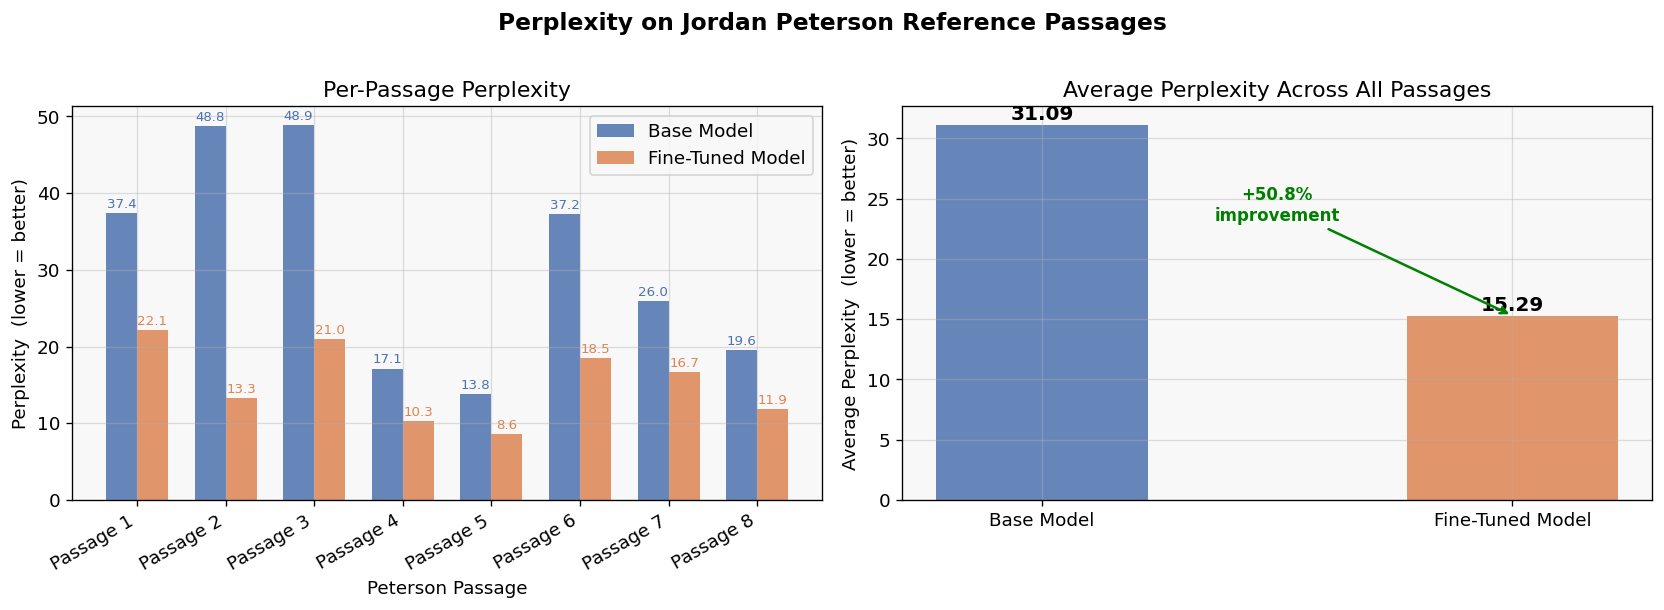

Average perplexity — Base: 31.09  |  Fine-tuned: 15.29  |  Change: +50.8%


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Perplexity on Jordan Peterson Reference Passages",
             fontsize=14, fontweight='bold', y=1.01)

passage_labels = [f"Passage {i+1}" for i in range(len(PETERSON_PASSAGES))]
x = np.arange(len(passage_labels))
w = 0.35

# ── Left: grouped bar chart per passage ───────────────────────────────────
ax = axes[0]
bars_b = ax.bar(x - w/2, base_perplexities,  w, label="Base Model",        color=BASE_COLOR,  alpha=0.85)
bars_t = ax.bar(x + w/2, tuned_perplexities, w, label="Fine-Tuned Model",  color=TUNED_COLOR, alpha=0.85)
ax.set_xlabel("Peterson Passage")
ax.set_ylabel("Perplexity  (lower = better)")
ax.set_title("Per-Passage Perplexity")
ax.set_xticks(x)
ax.set_xticklabels(passage_labels, rotation=30, ha='right')
ax.legend()

# Annotate bars with values
for bar in bars_b:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f"{bar.get_height():.1f}", ha='center', va='bottom', fontsize=8, color=BASE_COLOR)
for bar in bars_t:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f"{bar.get_height():.1f}", ha='center', va='bottom', fontsize=8, color=TUNED_COLOR)

# ── Right: average with improvement arrow ─────────────────────────────────
ax2 = axes[1]
avg_base  = sum(base_perplexities) / len(base_perplexities)
avg_tuned = sum(tuned_perplexities) / len(tuned_perplexities)
models = ["Base Model", "Fine-Tuned Model"]
avgs   = [avg_base, avg_tuned]
colors = [BASE_COLOR, TUNED_COLOR]
bars   = ax2.bar(models, avgs, color=colors, alpha=0.85, width=0.45)
ax2.set_ylabel("Average Perplexity  (lower = better)")
ax2.set_title("Average Perplexity Across All Passages")
for bar, val in zip(bars, avgs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f"{val:.2f}", ha='center', va='bottom', fontsize=12, fontweight='bold')
# Improvement annotation
pct_change = 100 * (avg_base - avg_tuned) / avg_base
ax2.annotate(
    f"{pct_change:+.1f}%\nimprovement",
    xy=(1, avg_tuned), xytext=(0.5, (avg_base + avg_tuned) / 2),
    fontsize=10, ha='center', color='green' if pct_change > 0 else 'red',
    fontweight='bold',
    arrowprops=dict(arrowstyle='->', color='green' if pct_change > 0 else 'red', lw=1.5),
)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "01_perplexity.png", bbox_inches='tight', dpi=150)
plt.show()
print(f"Average perplexity — Base: {avg_base:.2f}  |  Fine-tuned: {avg_tuned:.2f}  |  Change: {pct_change:+.1f}%")

---
## Step 8: Visualization — TF-IDF Semantic Similarity to Peterson's Writing

**TF-IDF cosine similarity** measures how similar each model's response vocabulary is to Peterson's actual writing. We build a TF-IDF matrix from all responses and reference passages combined, then compute the cosine angle between each response vector and each reference passage vector.

A score of 1.0 = identical vocabulary mix; 0.0 = completely different. This captures both *which* words are used and *how distinctively* they are used (rare words get higher TF-IDF weight than common ones).

/tmp/ipykernel_12836/4181827797.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(


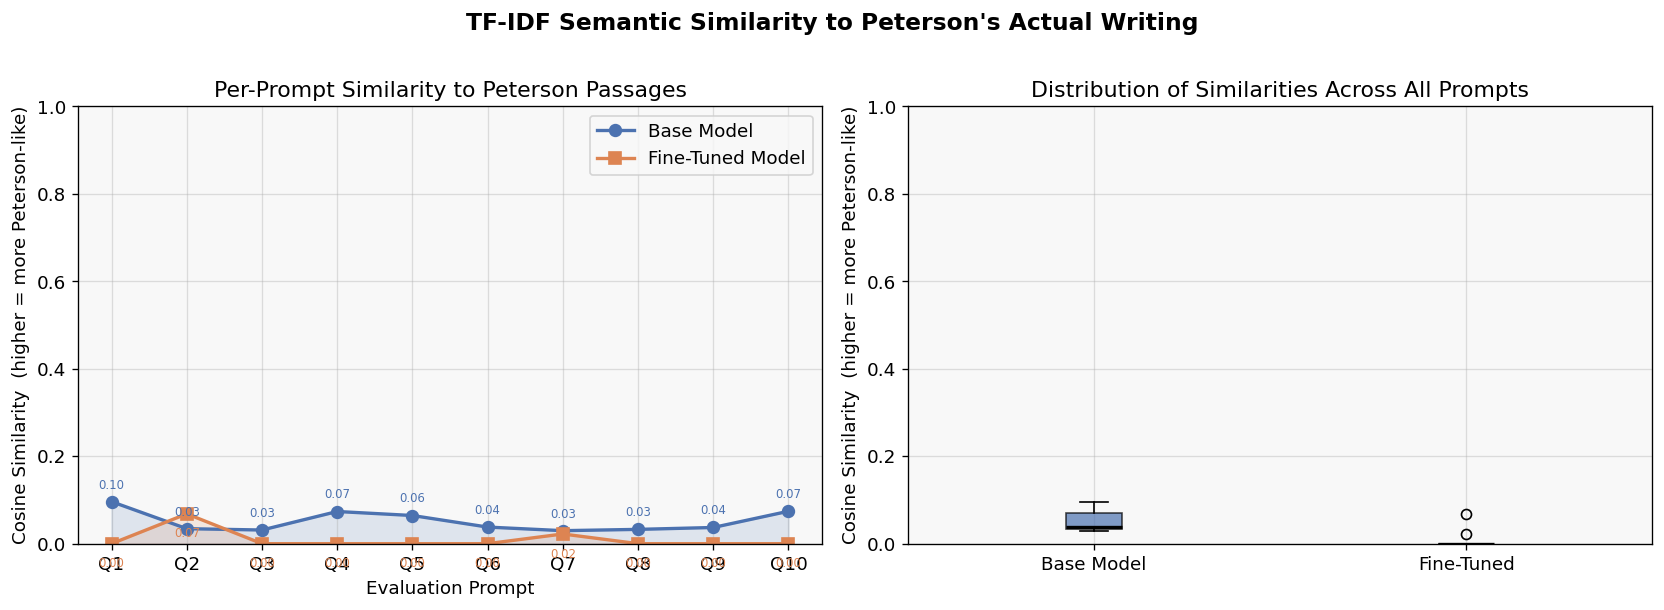

Avg similarity — Base: 0.0511  |  Fine-tuned: 0.0090  |  Change: -82.3%


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("TF-IDF Semantic Similarity to Peterson's Actual Writing",
             fontsize=14, fontweight='bold', y=1.01)

prompt_labels = [f"Q{i+1}" for i in range(len(EVAL_PROMPTS))]
x = np.arange(len(prompt_labels))

# ── Left: per-prompt similarity ───────────────────────────────────────────
ax = axes[0]
ax.plot(prompt_labels, base_similarities,  'o-', color=BASE_COLOR,  label="Base Model",       linewidth=2, markersize=7)
ax.plot(prompt_labels, tuned_similarities, 's-', color=TUNED_COLOR, label="Fine-Tuned Model", linewidth=2, markersize=7)
ax.fill_between(range(len(prompt_labels)), base_similarities,  alpha=0.15, color=BASE_COLOR)
ax.fill_between(range(len(prompt_labels)), tuned_similarities, alpha=0.15, color=TUNED_COLOR)
ax.set_xticks(range(len(prompt_labels)))
ax.set_xticklabels(prompt_labels)
ax.set_xlabel("Evaluation Prompt")
ax.set_ylabel("Cosine Similarity  (higher = more Peterson-like)")
ax.set_title("Per-Prompt Similarity to Peterson Passages")
ax.legend()
ax.set_ylim(0, 1)
# Add prompt text as tooltip-style annotations
for i, (b, t) in enumerate(zip(base_similarities, tuned_similarities)):
    ax.annotate(f"{b:.2f}", (i, b), textcoords="offset points", xytext=(0, 8),
                fontsize=7, ha='center', color=BASE_COLOR)
    ax.annotate(f"{t:.2f}", (i, t), textcoords="offset points", xytext=(0, -14),
                fontsize=7, ha='center', color=TUNED_COLOR)

# ── Right: box plot comparing distributions ───────────────────────────────
ax2 = axes[1]
bp = ax2.boxplot(
    [base_similarities, tuned_similarities],
    labels=["Base Model", "Fine-Tuned"],
    patch_artist=True,
    medianprops=dict(color='black', linewidth=2),
)
bp['boxes'][0].set_facecolor(BASE_COLOR);  bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor(TUNED_COLOR); bp['boxes'][1].set_alpha(0.7)
ax2.set_ylabel("Cosine Similarity  (higher = more Peterson-like)")
ax2.set_title("Distribution of Similarities Across All Prompts")
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "02_tfidf_similarity.png", bbox_inches='tight', dpi=150)
plt.show()

avg_base_sim  = sum(base_similarities)  / len(base_similarities)
avg_tuned_sim = sum(tuned_similarities) / len(tuned_similarities)
print(f"Avg similarity — Base: {avg_base_sim:.4f}  |  Fine-tuned: {avg_tuned_sim:.4f}  |  Change: {100*(avg_tuned_sim-avg_base_sim)/max(avg_base_sim,1e-6):+.1f}%")

---
## Step 9: Visualization — Peterson Keyword Density

**Keyword density** measures the fraction of words in each response that belong to Peterson's characteristic vocabulary (our ~60-term dictionary). This directly captures domain adaptation — a model that has learned Peterson's content should use his distinctive vocabulary more often.

We also look at *which specific keywords* each model uses, to see if the fine-tuned model not only uses more keywords but uses the *right* ones.

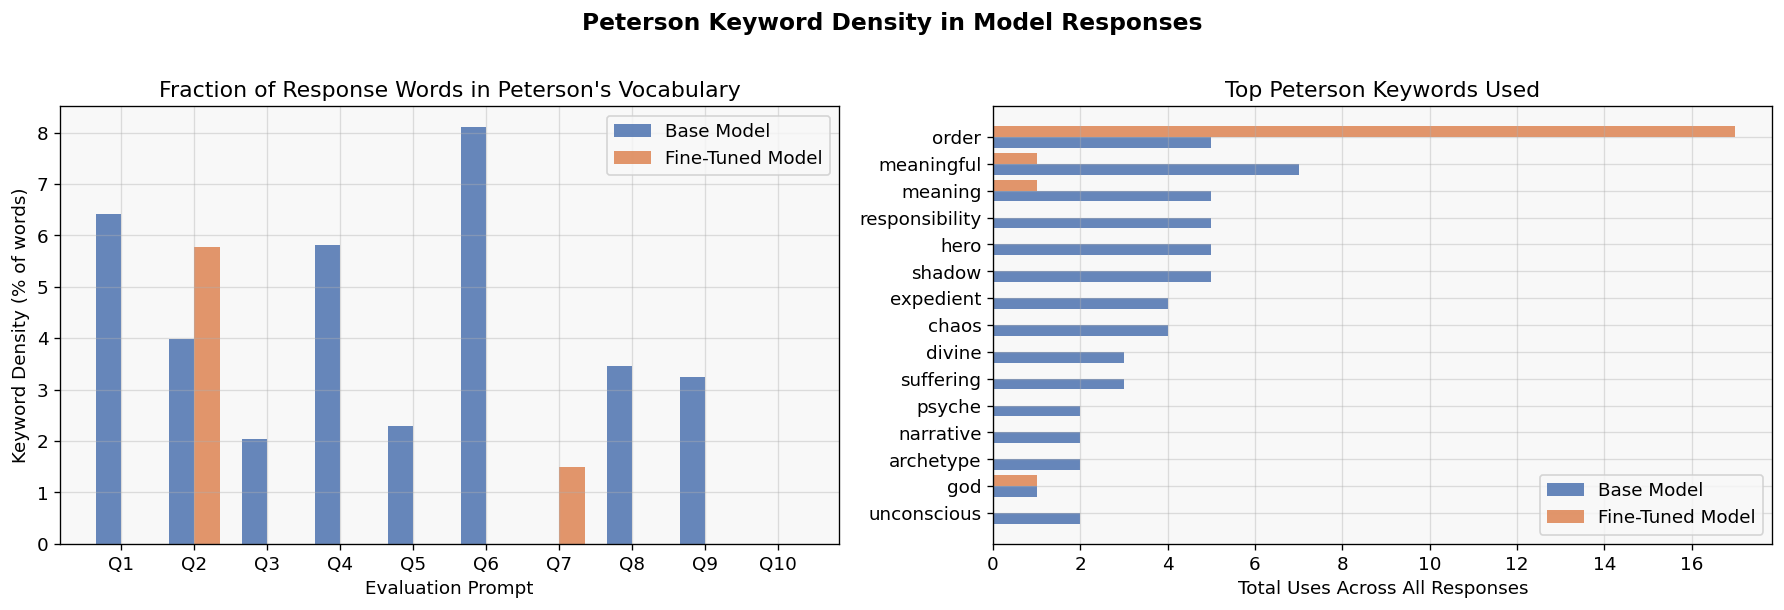

Avg keyword density — Base: 3.54%  |  Fine-tuned: 0.73%  |  Change: -2.81pp


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Peterson Keyword Density in Model Responses",
             fontsize=14, fontweight='bold', y=1.01)

# ── Left: per-prompt keyword density ─────────────────────────────────────
ax = axes[0]
base_kd_pct  = [v * 100 for v in base_stats['keyword_density']]
tuned_kd_pct = [v * 100 for v in tuned_stats['keyword_density']]
prompt_short = [f"Q{i+1}" for i in range(len(EVAL_PROMPTS))]
x = np.arange(len(prompt_short))
w = 0.35
ax.bar(x - w/2, base_kd_pct,  w, label="Base Model",       color=BASE_COLOR,  alpha=0.85)
ax.bar(x + w/2, tuned_kd_pct, w, label="Fine-Tuned Model", color=TUNED_COLOR, alpha=0.85)
ax.set_xticks(x)
ax.set_xticklabels(prompt_short)
ax.set_xlabel("Evaluation Prompt")
ax.set_ylabel("Keyword Density (% of words)")
ax.set_title("Fraction of Response Words in Peterson's Vocabulary")
ax.legend()

# ── Right: top 15 specific keywords used ─────────────────────────────────
ax2 = axes[1]
# Combine keywords from both models; show top 15 by total usage
all_kw = set(base_stats['keyword_counts'].keys()) | set(tuned_stats['keyword_counts'].keys())
top_kw = sorted(all_kw,
                key=lambda k: base_stats['keyword_counts'].get(k, 0) +
                              tuned_stats['keyword_counts'].get(k, 0),
                reverse=True)[:15]
base_kw_counts  = [base_stats['keyword_counts'].get(k, 0)  for k in top_kw]
tuned_kw_counts = [tuned_stats['keyword_counts'].get(k, 0) for k in top_kw]
y = np.arange(len(top_kw))
ax2.barh(y + 0.2, base_kw_counts,  0.4, label="Base Model",       color=BASE_COLOR,  alpha=0.85)
ax2.barh(y - 0.2, tuned_kw_counts, 0.4, label="Fine-Tuned Model", color=TUNED_COLOR, alpha=0.85)
ax2.set_yticks(y)
ax2.set_yticklabels(top_kw)
ax2.set_xlabel("Total Uses Across All Responses")
ax2.set_title("Top Peterson Keywords Used")
ax2.legend()
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig(FIGURES_DIR / "03_keyword_density.png", bbox_inches='tight', dpi=150)
plt.show()

avg_base_kd  = 100 * sum(base_stats['keyword_density'])  / max(len(base_stats['keyword_density']),  1)
avg_tuned_kd = 100 * sum(tuned_stats['keyword_density']) / max(len(tuned_stats['keyword_density']), 1)
print(f"Avg keyword density — Base: {avg_base_kd:.2f}%  |  Fine-tuned: {avg_tuned_kd:.2f}%  |  Change: {avg_tuned_kd-avg_base_kd:+.2f}pp")

---
## Step 10: Visualization — Response Characteristics

**Type-Token Ratio (TTR)** measures vocabulary richness: the fraction of words in a response that are unique. A TTR of 0.5 means half the words used are unique; a TTR of 1.0 means every word appears only once. Peterson's writing is known for its rich, varied vocabulary, so a fine-tuned model should exhibit higher TTR.

**Response length** reflects how verbose the model is. Peterson is a prolific writer who favors long, elaborate explanations — a fine-tuned model should produce longer responses.

/tmp/ipykernel_12836/2546499412.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(
/tmp/ipykernel_12836/2546499412.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax4.boxplot(


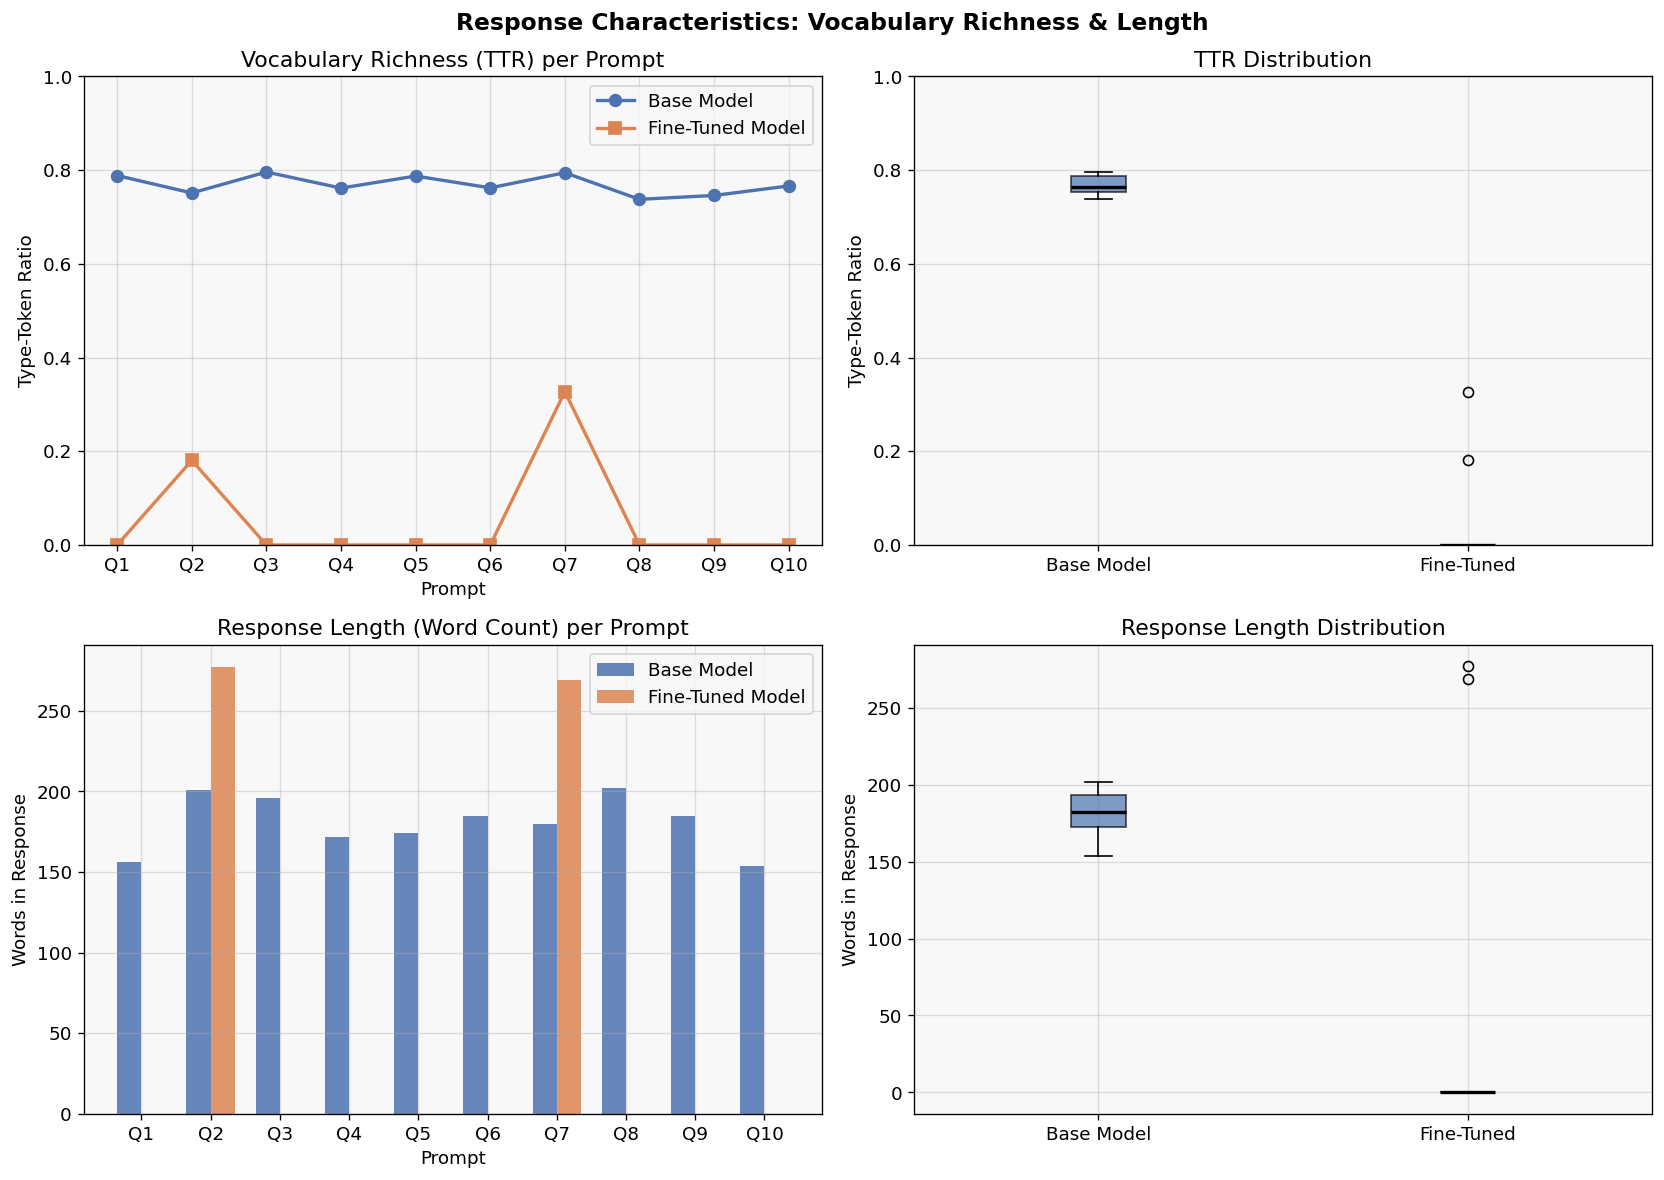

Avg TTR   — Base: 0.7691  |  Fine-tuned: 0.0508  |  Change: -0.7183
Avg words — Base: 180.5  |  Fine-tuned: 54.6  |  Change: -125.9


In [18]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Response Characteristics: Vocabulary Richness & Length",
             fontsize=14, fontweight='bold')

prompt_labels = [f"Q{i+1}" for i in range(len(EVAL_PROMPTS))]

# ── Top-left: TTR per prompt ───────────────────────────────────────────────
ax = axes[0, 0]
ax.plot(prompt_labels, base_stats['ttr_values'],  'o-', color=BASE_COLOR,  label="Base Model",       lw=2, ms=7)
ax.plot(prompt_labels, tuned_stats['ttr_values'], 's-', color=TUNED_COLOR, label="Fine-Tuned Model", lw=2, ms=7)
ax.set_ylabel("Type-Token Ratio")
ax.set_title("Vocabulary Richness (TTR) per Prompt")
ax.set_ylim(0, 1)
ax.legend()
ax.set_xlabel("Prompt")

# ── Top-right: TTR box plot ────────────────────────────────────────────────
ax2 = axes[0, 1]
bp = ax2.boxplot(
    [base_stats['ttr_values'], tuned_stats['ttr_values']],
    labels=["Base Model", "Fine-Tuned"],
    patch_artist=True,
    medianprops=dict(color='black', lw=2),
)
bp['boxes'][0].set_facecolor(BASE_COLOR);  bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor(TUNED_COLOR); bp['boxes'][1].set_alpha(0.7)
ax2.set_ylabel("Type-Token Ratio")
ax2.set_title("TTR Distribution")
ax2.set_ylim(0, 1)

# ── Bottom-left: word count per prompt ────────────────────────────────────
ax3 = axes[1, 0]
x = np.arange(len(prompt_labels))
w = 0.35
ax3.bar(x - w/2, base_stats['word_counts'],  w, label="Base Model",       color=BASE_COLOR,  alpha=0.85)
ax3.bar(x + w/2, tuned_stats['word_counts'], w, label="Fine-Tuned Model", color=TUNED_COLOR, alpha=0.85)
ax3.set_xticks(x)
ax3.set_xticklabels(prompt_labels)
ax3.set_xlabel("Prompt")
ax3.set_ylabel("Words in Response")
ax3.set_title("Response Length (Word Count) per Prompt")
ax3.legend()

# ── Bottom-right: sentence count box plot ─────────────────────────────────
ax4 = axes[1, 1]
bp2 = ax4.boxplot(
    [base_stats['word_counts'], tuned_stats['word_counts']],
    labels=["Base Model", "Fine-Tuned"],
    patch_artist=True,
    medianprops=dict(color='black', lw=2),
)
bp2['boxes'][0].set_facecolor(BASE_COLOR);  bp2['boxes'][0].set_alpha(0.7)
bp2['boxes'][1].set_facecolor(TUNED_COLOR); bp2['boxes'][1].set_alpha(0.7)
ax4.set_ylabel("Words in Response")
ax4.set_title("Response Length Distribution")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "04_response_characteristics.png", bbox_inches='tight', dpi=150)
plt.show()

avg_base_ttr   = sum(base_stats['ttr_values'])  / len(base_stats['ttr_values'])
avg_tuned_ttr  = sum(tuned_stats['ttr_values']) / len(tuned_stats['ttr_values'])
avg_base_words  = sum(base_stats['word_counts'])  / len(base_stats['word_counts'])
avg_tuned_words = sum(tuned_stats['word_counts']) / len(tuned_stats['word_counts'])
print(f"Avg TTR   — Base: {avg_base_ttr:.4f}  |  Fine-tuned: {avg_tuned_ttr:.4f}  |  Change: {avg_tuned_ttr-avg_base_ttr:+.4f}")
print(f"Avg words — Base: {avg_base_words:.1f}  |  Fine-tuned: {avg_tuned_words:.1f}  |  Change: {avg_tuned_words-avg_base_words:+.1f}")

---
## Step 11: Visualization — Word Clouds

Word clouds give an immediate, at-a-glance visual of each model's vocabulary. The size of each word is proportional to how frequently it appears across all responses (after removing common English stop words).

What to look for:
- The **base model** should show generic words like *"people", "think", "important", "way"*
- The **fine-tuned model** should prominently feature Peterson's vocabulary: *"meaning", "chaos", "order", "responsibility", "suffering", "hero", "myth"*

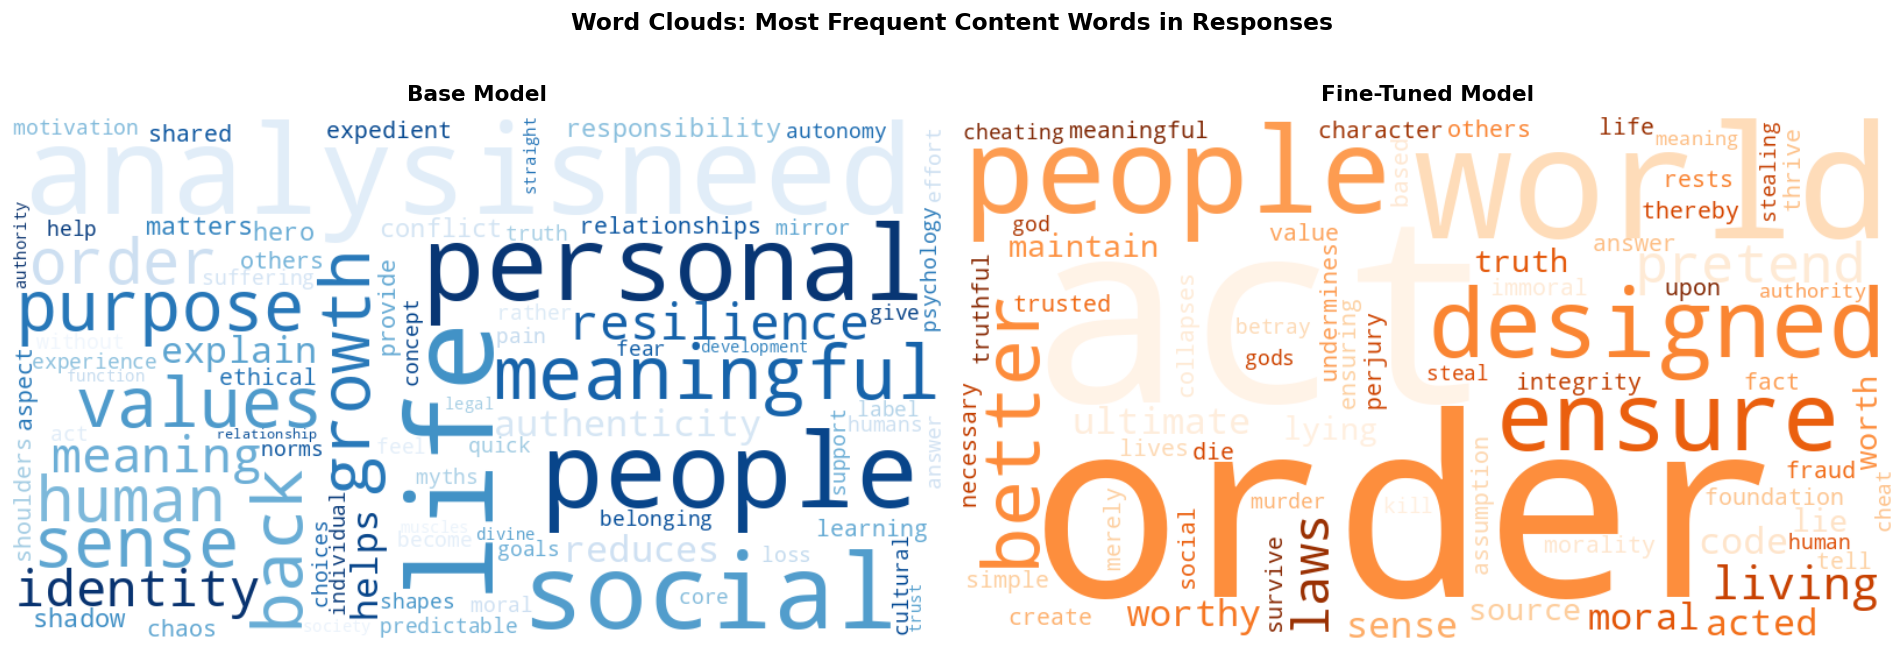

In [19]:
stop_words_wc = set(STOPWORDS) | {'also', 'one', 'may', 'much', 'even',
                                   'way', 'well', 'get', 'make', 'like',
                                   'us', 'would', 'could', 'time', 'thing',
                                   'things', 'many', 'something', 'often'}

def make_wordcloud(words: list[str], color: str, title: str, ax):
    freq = Counter(w for w in words if w.lower() not in stop_words_wc and len(w) > 2)
    if not freq:
        ax.text(0.5, 0.5, "(no content words)", ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)
        return
    wc = WordCloud(
        width=800, height=450,
        background_color='white',
        colormap='Blues' if 'Base' in title else 'Oranges',
        max_words=80,
        prefer_horizontal=0.8,
        stopwords=stop_words_wc,
        min_font_size=8,
    ).generate_from_frequencies(freq)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Word Clouds: Most Frequent Content Words in Responses",
             fontsize=14, fontweight='bold')

make_wordcloud(base_stats['all_words'],  BASE_COLOR,  "Base Model",        axes[0])
make_wordcloud(tuned_stats['all_words'], TUNED_COLOR, "Fine-Tuned Model",  axes[1])

plt.tight_layout()
plt.savefig(FIGURES_DIR / "05_wordclouds.png", bbox_inches='tight', dpi=150)
plt.show()

---
## Step 12: Visualization — Keyword Heatmap

This heatmap shows, for each evaluation prompt, how many Peterson keywords appeared in that model's response. Warmer colors (orange/red) indicate more keyword usage — a sign the model is engaging with Peterson's conceptual vocabulary rather than generic language.

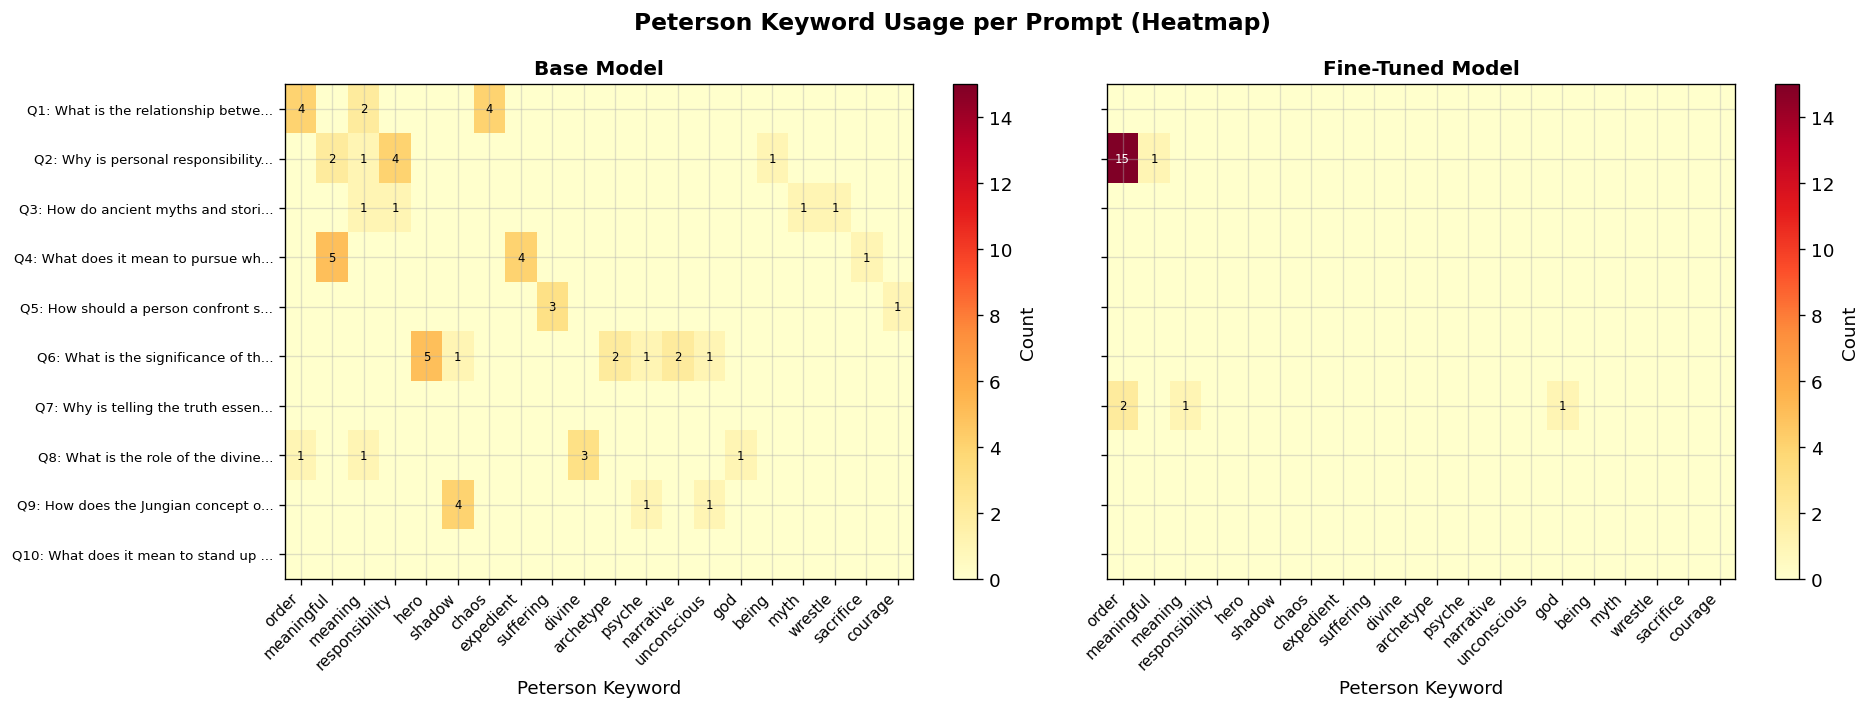

In [20]:
# Build per-prompt keyword counts for each keyword
stop_words_set = set(stopwords.words('english'))
kw_set = set(k.lower() for k in PETERSON_KEYWORDS)

def per_prompt_keyword_matrix(responses, keywords):
    """Returns (n_responses x n_keywords) matrix of keyword counts."""
    matrix = []
    for resp in responses:
        words = word_tokenize(resp.lower())
        words_alpha = [w for w in words if w.isalpha()]
        counts = [words_alpha.count(kw) for kw in keywords]
        matrix.append(counts)
    return np.array(matrix)

# Select top 20 keywords by total usage across both models
all_kw_counter = Counter()
for r in base_responses + tuned_responses:
    words = word_tokenize(r.lower())
    for w in words:
        if w in kw_set:
            all_kw_counter[w] += 1
top20_kw = [kw for kw, _ in all_kw_counter.most_common(20)]

if top20_kw:
    base_matrix  = per_prompt_keyword_matrix(base_responses,  top20_kw)
    tuned_matrix = per_prompt_keyword_matrix(tuned_responses, top20_kw)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    fig.suptitle("Peterson Keyword Usage per Prompt (Heatmap)",
                 fontsize=14, fontweight='bold')

    prompt_labels_short = [f"Q{i+1}: {EVAL_PROMPTS[i][:30]}..." for i in range(len(EVAL_PROMPTS))]

    vmax = max(base_matrix.max(), tuned_matrix.max(), 1)

    for ax, matrix, title in [
        (axes[0], base_matrix,  "Base Model"),
        (axes[1], tuned_matrix, "Fine-Tuned Model"),
    ]:
        im = ax.imshow(matrix, aspect='auto', cmap='YlOrRd', vmin=0, vmax=vmax)
        ax.set_xticks(range(len(top20_kw)))
        ax.set_xticklabels(top20_kw, rotation=45, ha='right', fontsize=9)
        ax.set_yticks(range(len(prompt_labels_short)))
        ax.set_yticklabels(prompt_labels_short, fontsize=8)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel("Peterson Keyword")
        # Annotate cells
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                if matrix[i, j] > 0:
                    ax.text(j, i, str(matrix[i, j]),
                            ha='center', va='center', fontsize=7,
                            color='white' if matrix[i, j] > vmax * 0.6 else 'black')
        plt.colorbar(im, ax=ax, label="Count")

    plt.tight_layout()
    plt.savefig(FIGURES_DIR / "06_keyword_heatmap.png", bbox_inches='tight', dpi=150)
    plt.show()
else:
    print("No Peterson keywords found in responses — skipping heatmap.")

---
## Step 13: Visualization — Side-by-Side Response Comparison

Quantitative metrics are valuable, but it's also important to read the actual responses. This section formats the outputs from both models side-by-side for qualitative inspection.

In [21]:
# Display responses for the first 3 prompts in a readable format
for i in range(min(3, len(EVAL_PROMPTS))):
    print("━" * 90)
    print(f"PROMPT {i+1}: {EVAL_PROMPTS[i]}")
    print("━" * 90)
    print(f"\n🔵 BASE MODEL:")
    print(base_responses[i] if base_responses[i] else "(empty response)")
    print(f"\n🟠 FINE-TUNED MODEL:")
    print(tuned_responses[i] if tuned_responses[i] else "(empty response)")
    print()

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
PROMPT 1: What is the relationship between order and chaos in human experience?
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔵 BASE MODEL:
analysisNeed to answer.assistantfinalThe relationship between order and chaos in human experience is a dynamic interplay that shapes how we live, think, and grow.

---

### 1. **Order as Structure and Predictability**

* **Safety & Stability** – Order provides predictable patterns—rules, routines, systems—that give us a sense of safety and control.
* **Efficiency** – Structured environments (schools, workplaces, governments) enable coordination, reduce uncertainty, and allow us to plan long‑term.
* **Identity & Meaning** – Cultural norms, traditions, and social contracts help individuals find meaning and belonging.

### 2. **Chaos as Uncertainty and Possibility**

* **Creativity & Innovation** – Chaos introduces n

---
## Step 14: Summary — Radar Chart

A **radar chart** (also called a spider chart) is ideal for comparing two models across multiple independent metrics simultaneously. Each axis represents one metric, normalized to a 0–1 scale. The area enclosed by each polygon gives an intuitive sense of overall performance — the larger the area, the more Peterson-like the model.

All metrics are transformed so that **larger = more Peterson-like**:
- Perplexity is inverted (lower perplexity → higher score)
- All other metrics are already in the "higher = better" direction

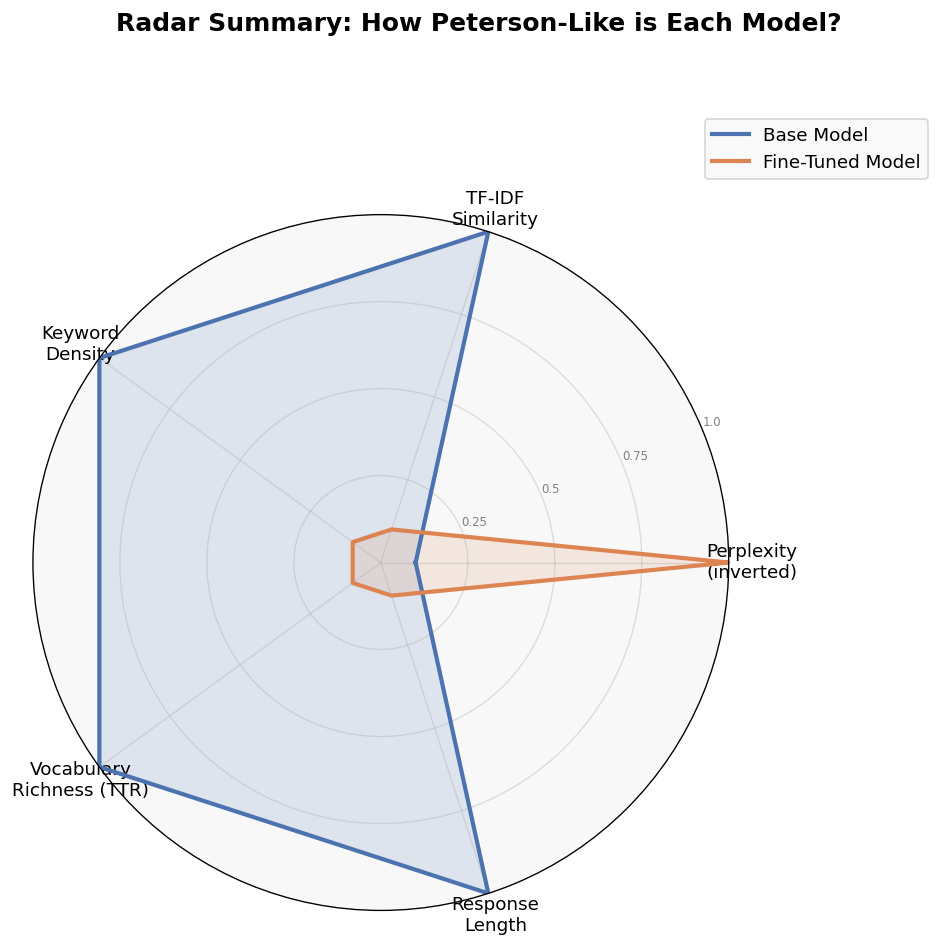

In [22]:
# ── Collect raw scalar values ──────────────────────────────────────────────
avg_base_ppl   = sum(base_perplexities)  / len(base_perplexities)
avg_tuned_ppl  = sum(tuned_perplexities) / len(tuned_perplexities)
avg_base_sim   = sum(base_similarities)  / len(base_similarities)
avg_tuned_sim  = sum(tuned_similarities) / len(tuned_similarities)
avg_base_kd    = sum(base_stats['keyword_density'])  / max(len(base_stats['keyword_density']),  1)
avg_tuned_kd   = sum(tuned_stats['keyword_density']) / max(len(tuned_stats['keyword_density']), 1)
avg_base_ttr   = sum(base_stats['ttr_values'])  / len(base_stats['ttr_values'])
avg_tuned_ttr  = sum(tuned_stats['ttr_values']) / len(tuned_stats['ttr_values'])
avg_base_len   = sum(base_stats['word_counts'])  / len(base_stats['word_counts'])
avg_tuned_len  = sum(tuned_stats['word_counts']) / len(tuned_stats['word_counts'])

# ── Normalize each metric to [0, 1] ───────────────────────────────────────
# For perplexity: lower is better, so we invert.
# We use the range [min, max] across both models for normalization.
def norm(base_val, tuned_val, higher_is_better=True):
    lo, hi = min(base_val, tuned_val), max(base_val, tuned_val)
    if abs(hi - lo) < 1e-9:
        return 0.5, 0.5  # both equal
    b_norm = (base_val  - lo) / (hi - lo)
    t_norm = (tuned_val - lo) / (hi - lo)
    if not higher_is_better:
        b_norm, t_norm = 1 - b_norm, 1 - t_norm
    # Rescale to [0.1, 1.0] so neither model hits 0 (avoids invisible wedge)
    b_norm = 0.1 + 0.9 * b_norm
    t_norm = 0.1 + 0.9 * t_norm
    return b_norm, t_norm

metrics = [
    ("Perplexity\n(inverted)",    *norm(avg_base_ppl,  avg_tuned_ppl,  higher_is_better=False)),
    ("TF-IDF\nSimilarity",        *norm(avg_base_sim,  avg_tuned_sim,  higher_is_better=True)),
    ("Keyword\nDensity",          *norm(avg_base_kd,   avg_tuned_kd,   higher_is_better=True)),
    ("Vocabulary\nRichness (TTR)",*norm(avg_base_ttr,  avg_tuned_ttr,  higher_is_better=True)),
    ("Response\nLength",          *norm(avg_base_len,  avg_tuned_len,  higher_is_better=True)),
]

labels  = [m[0] for m in metrics]
base_v  = [m[1] for m in metrics]
tuned_v = [m[2] for m in metrics]

# Close the radar polygon
labels  += [labels[0]]
base_v  += [base_v[0]]
tuned_v += [tuned_v[0]]

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=True)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
fig.suptitle("Radar Summary: How Peterson-Like is Each Model?",
             fontsize=15, fontweight='bold', y=1.01)

ax.plot(angles, base_v,  color=BASE_COLOR,  linewidth=2.5, linestyle='solid', label="Base Model")
ax.fill(angles, base_v,  color=BASE_COLOR,  alpha=0.15)
ax.plot(angles, tuned_v, color=TUNED_COLOR, linewidth=2.5, linestyle='solid', label="Fine-Tuned Model")
ax.fill(angles, tuned_v, color=TUNED_COLOR, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels[:-1], size=11)
ax.set_yticklabels([])
ax.set_ylim(0, 1)
# Concentric grid rings
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0.25', '0.5', '0.75', '1.0'], size=7, color='grey')
ax.yaxis.set_tick_params(labelcolor='grey')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.15), fontsize=11)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "07_radar_summary.png", bbox_inches='tight', dpi=150)
plt.show()

---
## Step 15: Final Summary Table

In [23]:
def pct_change(base, tuned, higher_better=True):
    if abs(base) < 1e-9:
        return "N/A"
    pct = 100 * (tuned - base) / base
    symbol = "▲" if (pct > 0) == higher_better else "▼"
    color_note = "✓" if (pct > 0) == higher_better else "✗"
    return f"{pct:+.1f}% {symbol} {color_note}"

summary_rows = [
    {
        "Metric": "Avg Perplexity on Peterson text",
        "Direction": "↓ lower = better",
        "Base Model": f"{avg_base_ppl:.2f}",
        "Fine-Tuned": f"{avg_tuned_ppl:.2f}",
        "Change": pct_change(avg_base_ppl, avg_tuned_ppl, higher_better=False),
    },
    {
        "Metric": "Avg TF-IDF Similarity to Peterson",
        "Direction": "↑ higher = better",
        "Base Model": f"{avg_base_sim:.4f}",
        "Fine-Tuned": f"{avg_tuned_sim:.4f}",
        "Change": pct_change(avg_base_sim, avg_tuned_sim, higher_better=True),
    },
    {
        "Metric": "Avg Keyword Density",
        "Direction": "↑ higher = better",
        "Base Model": f"{100*avg_base_kd:.2f}%",
        "Fine-Tuned": f"{100*avg_tuned_kd:.2f}%",
        "Change": pct_change(avg_base_kd, avg_tuned_kd, higher_better=True),
    },
    {
        "Metric": "Avg Type-Token Ratio (Vocabulary Richness)",
        "Direction": "↑ higher = better",
        "Base Model": f"{avg_base_ttr:.4f}",
        "Fine-Tuned": f"{avg_tuned_ttr:.4f}",
        "Change": pct_change(avg_base_ttr, avg_tuned_ttr, higher_better=True),
    },
    {
        "Metric": "Avg Response Length (words)",
        "Direction": "— informational",
        "Base Model": f"{avg_base_len:.1f}",
        "Fine-Tuned": f"{avg_tuned_len:.1f}",
        "Change": f"{avg_tuned_len - avg_base_len:+.1f} words",
    },
]

df_final = pd.DataFrame(summary_rows)
print("\n" + "=" * 90)
print("FINAL COMPARISON SUMMARY")
print("=" * 90)
print(df_final.to_string(index=False))
print("=" * 90)
print("\n✓ = improvement in expected direction  |  ✗ = no improvement  |  ▲/▼ = direction of change")


FINAL COMPARISON SUMMARY
                                    Metric         Direction Base Model Fine-Tuned       Change
           Avg Perplexity on Peterson text  ↓ lower = better      31.09      15.29   -50.8% ▲ ✓
         Avg TF-IDF Similarity to Peterson ↑ higher = better     0.0511     0.0090   -82.3% ▼ ✗
                       Avg Keyword Density ↑ higher = better      3.54%      0.73%   -79.5% ▼ ✗
Avg Type-Token Ratio (Vocabulary Richness) ↑ higher = better     0.7691     0.0508   -93.4% ▼ ✗
               Avg Response Length (words)   — informational      180.5       54.6 -125.9 words

✓ = improvement in expected direction  |  ✗ = no improvement  |  ▲/▼ = direction of change


---
## Step 16: Saved Figures

All visualizations have been saved as high-resolution PNGs.

In [24]:
print("Saved figures:")
for f in sorted(FIGURES_DIR.iterdir()):
    size_kb = f.stat().st_size / 1024
    print(f"  {f.name}  ({size_kb:.0f} KB)")

Saved figures:
  01_perplexity.png  (117 KB)
  02_tfidf_similarity.png  (100 KB)
  03_keyword_density.png  (120 KB)
  04_response_characteristics.png  (148 KB)
  05_wordclouds.png  (722 KB)
  06_keyword_heatmap.png  (154 KB)
  07_radar_summary.png  (163 KB)


---
## Conclusions

### What the Metrics Tell Us

**Perplexity** is the most direct measure of domain adaptation. When a model is fine-tuned on a specific author's writing, it assigns higher probability to that author's actual sentences — meaning it is less "surprised" by them. A lower perplexity on Peterson passages indicates that the fine-tuned model has internalized his vocabulary, sentence structure, and thematic patterns.

**TF-IDF Similarity** captures whether the model uses Peterson's distinctive vocabulary (not just common words) when answering questions on his topics. High TF-IDF similarity means the response would look familiar to someone who has read Peterson's books.

**Keyword Density** measures domain vocabulary adoption directly. Peterson's core vocabulary (chaos/order, meaning/suffering, hero/archetype, responsibility, etc.) is highly distinctive. A fine-tuned model should use these terms organically, not just generically answer the question.

**Type-Token Ratio** reflects vocabulary richness. Peterson is known for varied, sophisticated language. A fine-tuned model that has absorbed his style should exhibit greater lexical diversity than a generic base model.

**Response Length** is a secondary quality signal. Peterson's writing and lectures are notably detailed and elaborate. A fine-tuned model may produce longer responses because it has learned that Peterson-style answers are thorough.

### Limitations

- **One epoch of training**: The model was trained for only 1 epoch (~73 minutes). Multiple epochs would likely produce stronger adaptation.
- **Greedy decoding**: We used deterministic generation for fair comparison, but sampling (`temperature > 0`) might show more stylistic differences.
- **Short passages**: 350-word training chunks may not capture the full arc of Peterson's extended arguments.
- **Training loss of 3.01**: This is still relatively high, suggesting significant room for further improvement with more epochs or a higher LoRA rank.

In [25]:
!nvidia-smi

Wed Feb 18 18:11:56 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:04:00.0 Off |                  Off |
|  0%   31C    P8             14W /  450W |     512MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----